In [28]:
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import termcolor
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

from vision_models import Plot
from metacognitive_pipeline import fine_grain_classes, n_classes

# Data loading

In [3]:
data_dir = '.'  # Set the directory where your .npy files are located

# Initialize dictionaries to store training and test accuracy data for each model
model_train_data = {}
model_test_data = {}

test_true = np.load(os.path.join(data_dir, 'test_true.npy'))

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    train_match = re.match(pattern=r'(.+?)_train_(loss|acc)_lr(.+?)_e(\d+?).npy',
                           string=filename)
    test_match = re.match(pattern=r'(.+?)_test_pred_lr(.+?)_e(\d+?).npy',
                          string=filename)

    if train_match:
        model_name = train_match.group(1)
        metric = train_match.group(2)
        lr_value = float(train_match.group(3))
        num_epochs = int(train_match.group(4)) + 1

        # Load the data from the .npy file
        data = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_data dictionary
        if model_name not in model_train_data:
            model_train_data[model_name] = {}
        if metric not in model_train_data[model_name]:
            model_train_data[model_name][metric] = {}
        if lr_value not in model_train_data[model_name][metric]:
            model_train_data[model_name][metric][lr_value] = {}

        model_train_data[model_name][metric][lr_value][num_epochs] = data[-1]
    elif test_match:
        model_name = test_match.group(1)
        lr_value = float(test_match.group(2))
        num_epochs = int(test_match.group(3)) + 1

        # Load the test data from the .npy file
        test_pred = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_test_data dictionary
        if model_name not in model_test_data:
            model_test_data[model_name] = {}
        if lr_value not in model_test_data[model_name]:
            model_test_data[model_name][lr_value] = {}

        model_test_data[model_name][lr_value][num_epochs] = \
            {'acc': accuracy_score(test_true, test_pred), 
             'cm': confusion_matrix(test_true, test_pred),
             'pre': precision_score(test_true, test_pred, labels=range(n_classes), average=None),
             'rec': recall_score(test_true, test_pred, labels=range(n_classes), average=None),
             'f1': f1_score(test_true, test_pred, labels=range(n_classes), average=None)}

# Train metrics


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


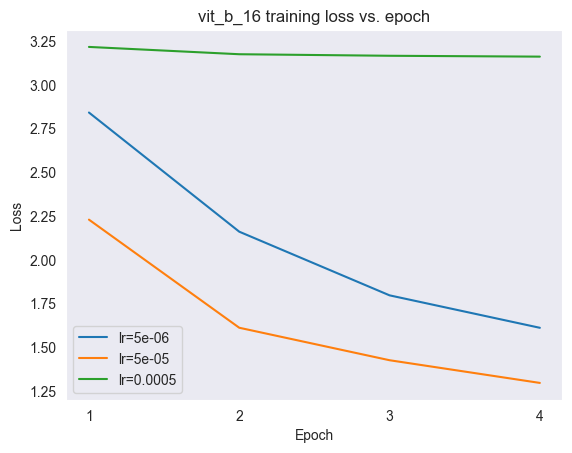

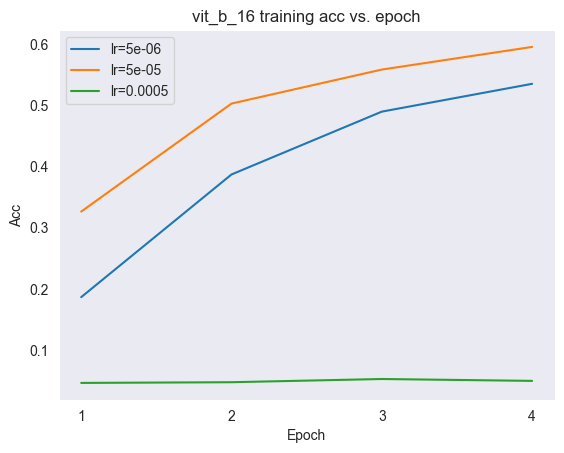


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


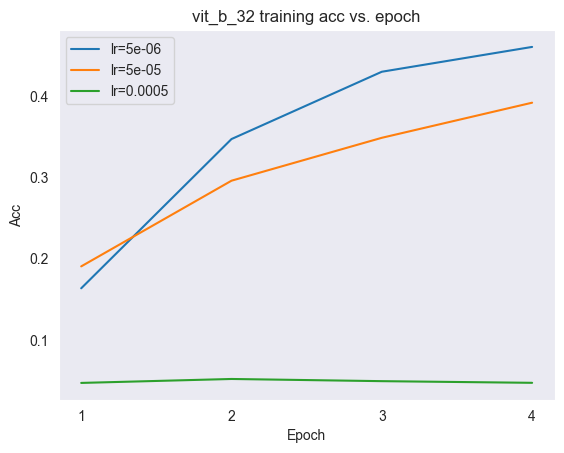

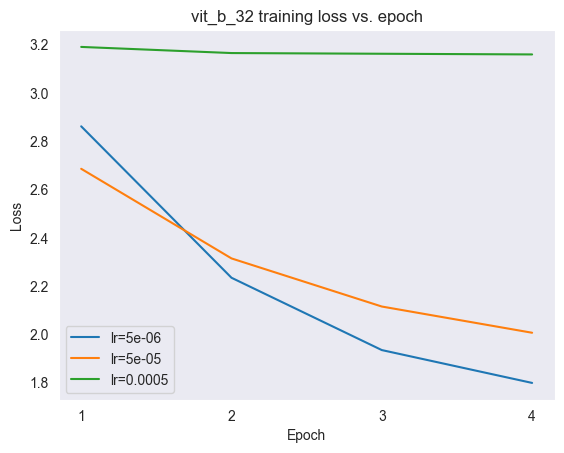


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


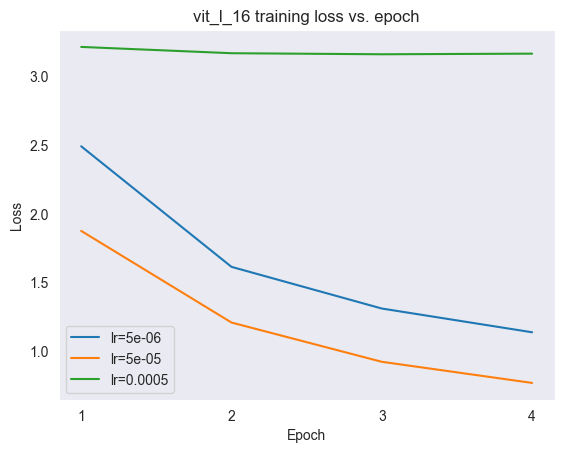

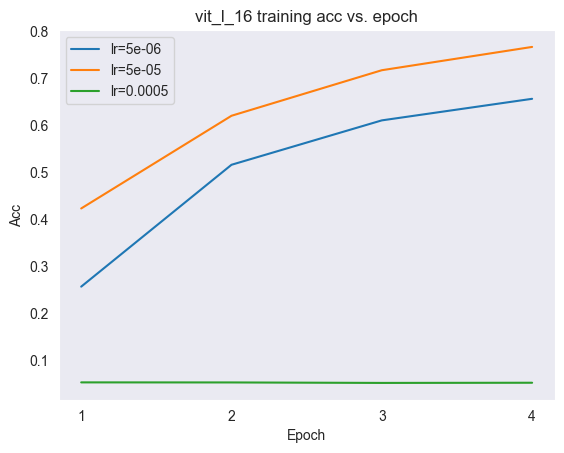


############################################################################################################
##################################################vit_l_32##################################################
############################################################################################################


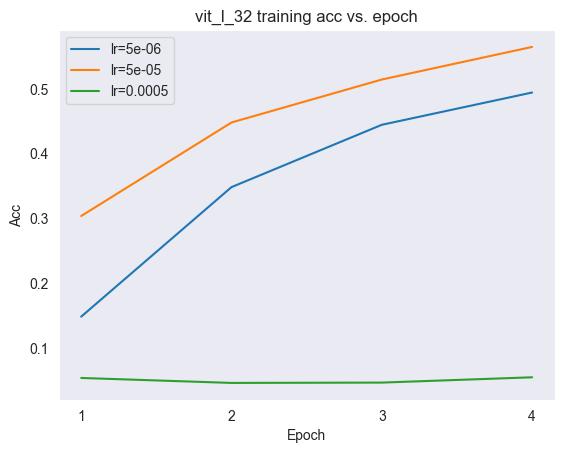

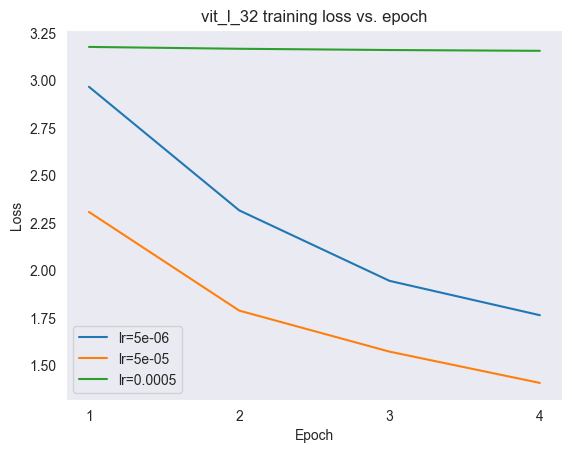

<Figure size 640x480 with 0 Axes>

In [4]:
def plot_train_metrics():
    # Create plots for training metric vs. epoch for each model
    for model_name, model_data in sorted(model_train_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        for metric, metric_data in model_data.items():
            with Plot():
                plt.title(f"{model_name} training {metric} vs. epoch")
                plt.xlabel('Epoch')
                plt.ylabel(metric.capitalize())
    
                for lr_value, lr_data in sorted(metric_data.items()):
                    epochs, data = zip(*sorted(lr_data.items())) # Sort the data based on the number of epochs
                    plt.plot(epochs, data, label=f'lr={lr_value}')
                    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
    
                plt.legend()
                plt.grid()

plot_train_metrics()


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


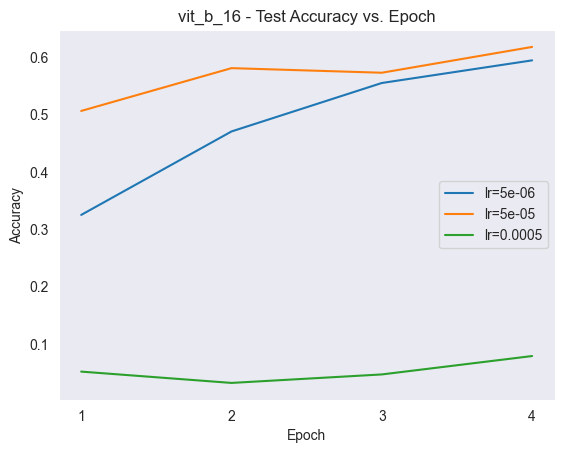

<Figure size 640x480 with 0 Axes>

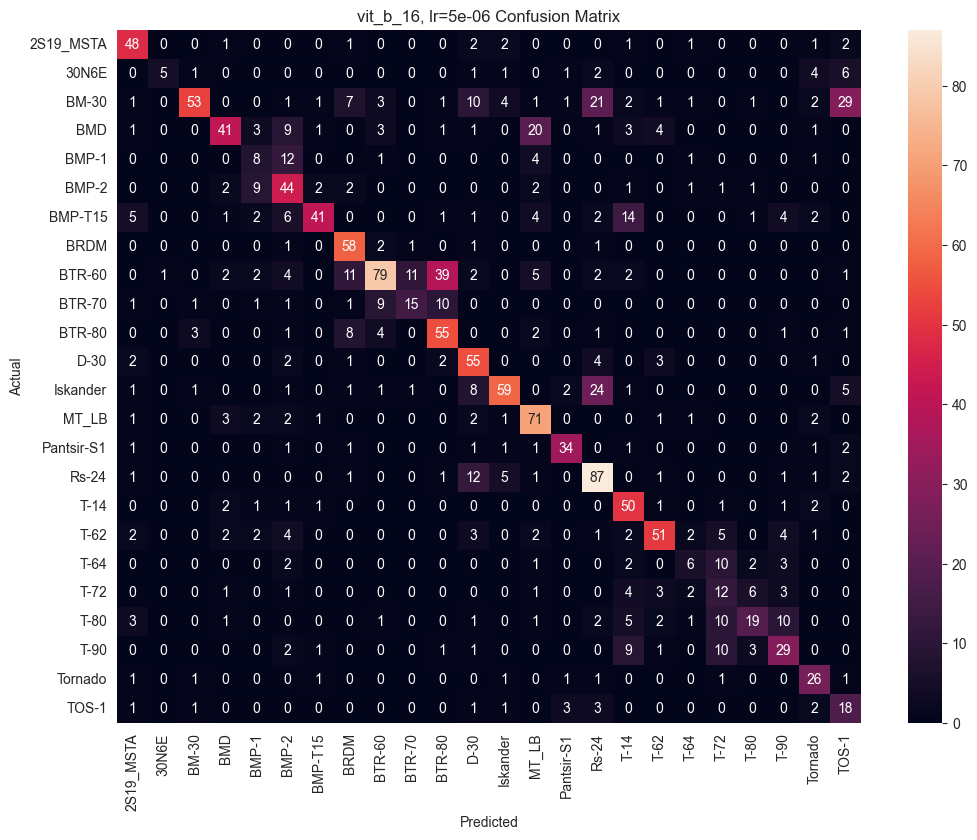

vit_b_16, lr=5e-06, 2S19_MSTA: Precision = 0.70
vit_b_16, lr=5e-06, 30N6E: Precision = 0.83
vit_b_16, lr=5e-06, BM-30: Precision = 0.87
vit_b_16, lr=5e-06, BMD: Precision = 0.73
vit_b_16, lr=5e-06, BMP-1: Precision = 0.27
vit_b_16, lr=5e-06, BMP-2: Precision = 0.46
vit_b_16, lr=5e-06, BMP-T15: Precision = 0.84
vit_b_16, lr=5e-06, BRDM: Precision = 0.63
vit_b_16, lr=5e-06, BTR-60: Precision = 0.77
vit_b_16, lr=5e-06, BTR-70: Precision = 0.54
vit_b_16, lr=5e-06, BTR-80: Precision = 0.50
vit_b_16, lr=5e-06, D-30: Precision = 0.54
vit_b_16, lr=5e-06, Iskander: Precision = 0.79
vit_b_16, lr=5e-06, MT_LB: Precision = 0.61
vit_b_16, lr=5e-06, Pantsir-S1: Precision = 0.81
vit_b_16, lr=5e-06, Rs-24: Precision = 0.57
vit_b_16, lr=5e-06, T-14: Precision = 0.52
vit_b_16, lr=5e-06, T-62: Precision = 0.75
vit_b_16, lr=5e-06, T-64: Precision = 0.38
vit_b_16, lr=5e-06, T-72: Precision = 0.24
vit_b_16, lr=5e-06, T-80: Precision = 0.58
vit_b_16, lr=5e-06, T-90: Precision = 0.52
vit_b_16, lr=5e-06, Torna

<Figure size 640x480 with 0 Axes>

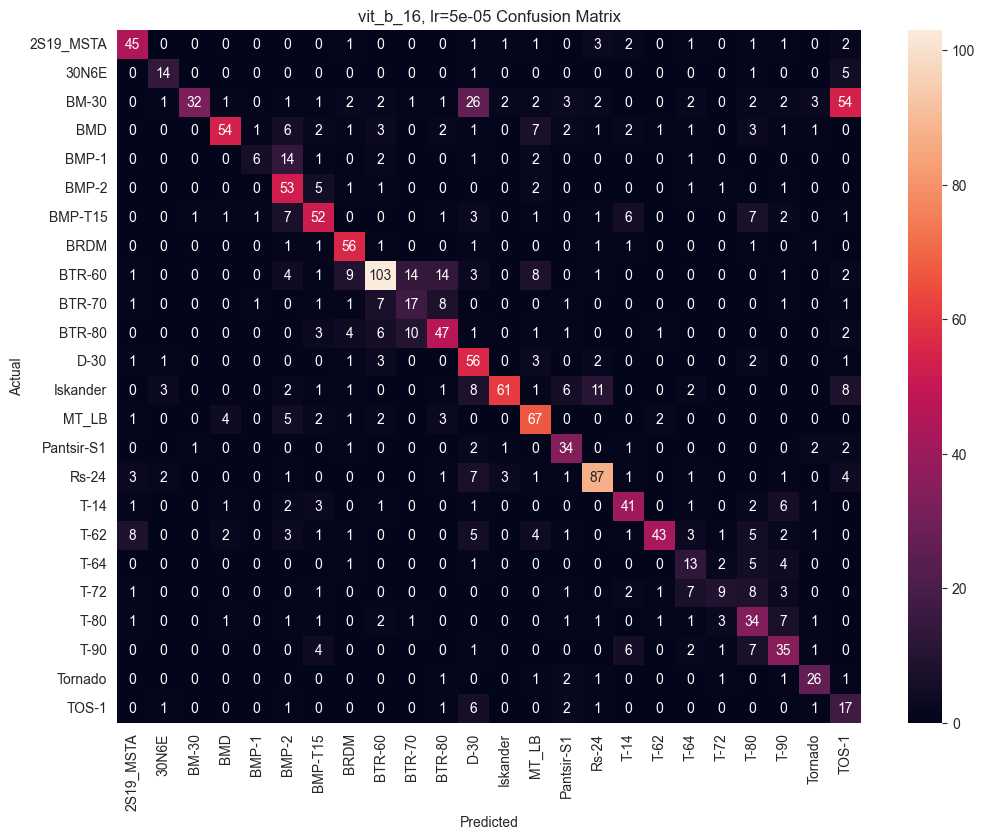

vit_b_16, lr=5e-05, 2S19_MSTA: Precision = 0.71
vit_b_16, lr=5e-05, 30N6E: Precision = 0.64
vit_b_16, lr=5e-05, BM-30: Precision = 0.94
vit_b_16, lr=5e-05, BMD: Precision = 0.84
vit_b_16, lr=5e-05, BMP-1: Precision = 0.67
vit_b_16, lr=5e-05, BMP-2: Precision = 0.52
vit_b_16, lr=5e-05, BMP-T15: Precision = 0.65
vit_b_16, lr=5e-05, BRDM: Precision = 0.69
vit_b_16, lr=5e-05, BTR-60: Precision = 0.77
vit_b_16, lr=5e-05, BTR-70: Precision = 0.40
vit_b_16, lr=5e-05, BTR-80: Precision = 0.59
vit_b_16, lr=5e-05, D-30: Precision = 0.45
vit_b_16, lr=5e-05, Iskander: Precision = 0.90
vit_b_16, lr=5e-05, MT_LB: Precision = 0.66
vit_b_16, lr=5e-05, Pantsir-S1: Precision = 0.62
vit_b_16, lr=5e-05, Rs-24: Precision = 0.78
vit_b_16, lr=5e-05, T-14: Precision = 0.65
vit_b_16, lr=5e-05, T-62: Precision = 0.88
vit_b_16, lr=5e-05, T-64: Precision = 0.36
vit_b_16, lr=5e-05, T-72: Precision = 0.50
vit_b_16, lr=5e-05, T-80: Precision = 0.44
vit_b_16, lr=5e-05, T-90: Precision = 0.51
vit_b_16, lr=5e-05, Torna

<Figure size 640x480 with 0 Axes>

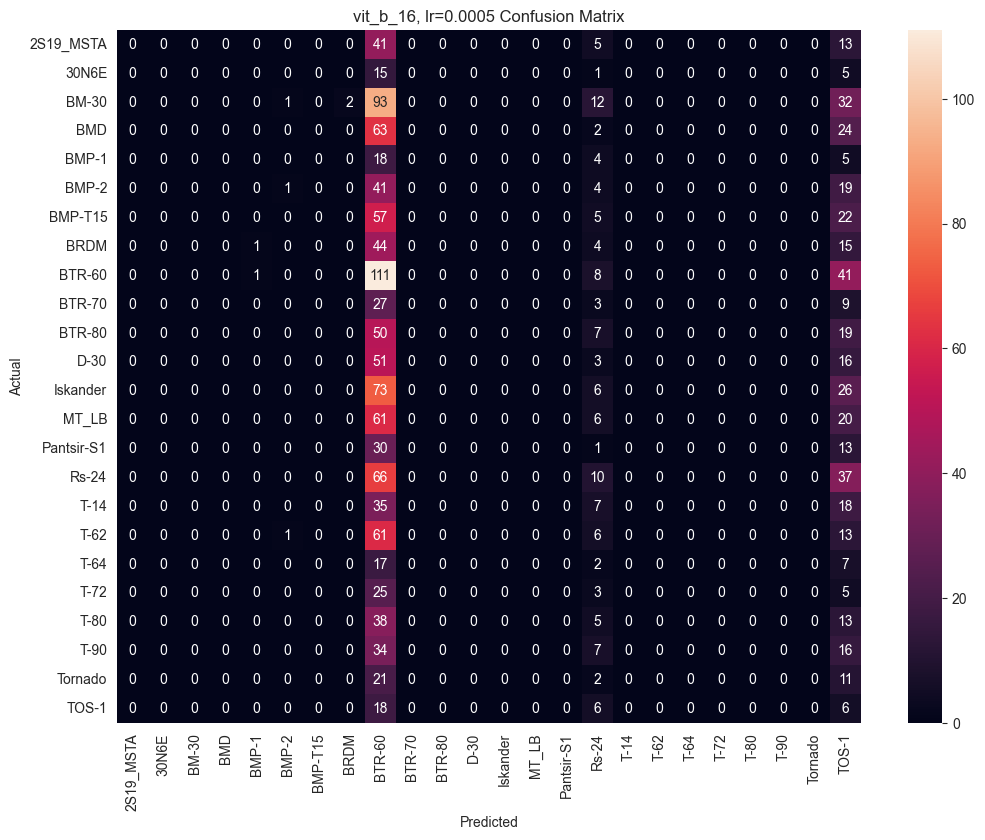

vit_b_16, lr=0.0005, 2S19_MSTA: Precision = 0.00
vit_b_16, lr=0.0005, 30N6E: Precision = 0.00
vit_b_16, lr=0.0005, BM-30: Precision = 0.00
vit_b_16, lr=0.0005, BMD: Precision = 0.00
vit_b_16, lr=0.0005, BMP-1: Precision = 0.00
vit_b_16, lr=0.0005, BMP-2: Precision = 0.33
vit_b_16, lr=0.0005, BMP-T15: Precision = 0.00
vit_b_16, lr=0.0005, BRDM: Precision = 0.00
vit_b_16, lr=0.0005, BTR-60: Precision = 0.10
vit_b_16, lr=0.0005, BTR-70: Precision = 0.00
vit_b_16, lr=0.0005, BTR-80: Precision = 0.00
vit_b_16, lr=0.0005, D-30: Precision = 0.00
vit_b_16, lr=0.0005, Iskander: Precision = 0.00
vit_b_16, lr=0.0005, MT_LB: Precision = 0.00
vit_b_16, lr=0.0005, Pantsir-S1: Precision = 0.00
vit_b_16, lr=0.0005, Rs-24: Precision = 0.08
vit_b_16, lr=0.0005, T-14: Precision = 0.00
vit_b_16, lr=0.0005, T-62: Precision = 0.00
vit_b_16, lr=0.0005, T-64: Precision = 0.00
vit_b_16, lr=0.0005, T-72: Precision = 0.00
vit_b_16, lr=0.0005, T-80: Precision = 0.00
vit_b_16, lr=0.0005, T-90: Precision = 0.00
vit

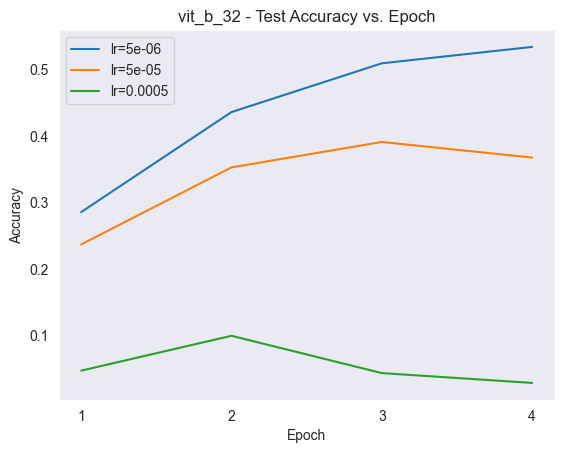

<Figure size 640x480 with 0 Axes>

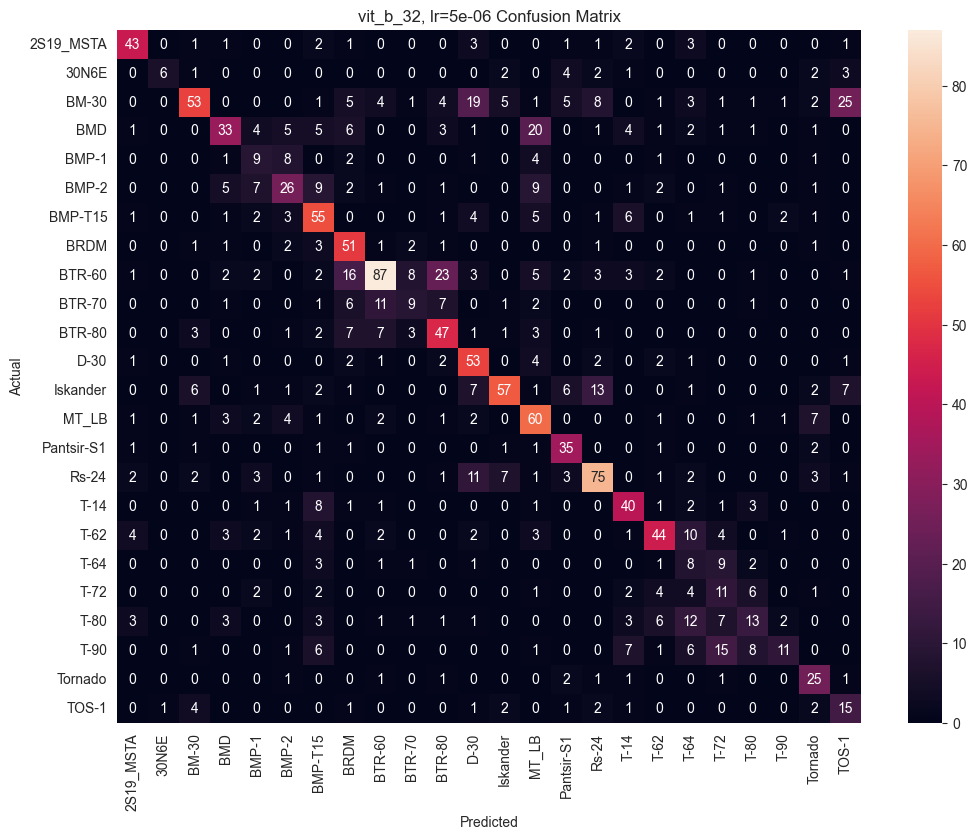

vit_b_32, lr=5e-06, 2S19_MSTA: Precision = 0.74
vit_b_32, lr=5e-06, 30N6E: Precision = 0.86
vit_b_32, lr=5e-06, BM-30: Precision = 0.72
vit_b_32, lr=5e-06, BMD: Precision = 0.60
vit_b_32, lr=5e-06, BMP-1: Precision = 0.26
vit_b_32, lr=5e-06, BMP-2: Precision = 0.48
vit_b_32, lr=5e-06, BMP-T15: Precision = 0.50
vit_b_32, lr=5e-06, BRDM: Precision = 0.50
vit_b_32, lr=5e-06, BTR-60: Precision = 0.72
vit_b_32, lr=5e-06, BTR-70: Precision = 0.36
vit_b_32, lr=5e-06, BTR-80: Precision = 0.51
vit_b_32, lr=5e-06, D-30: Precision = 0.48
vit_b_32, lr=5e-06, Iskander: Precision = 0.75
vit_b_32, lr=5e-06, MT_LB: Precision = 0.49
vit_b_32, lr=5e-06, Pantsir-S1: Precision = 0.59
vit_b_32, lr=5e-06, Rs-24: Precision = 0.68
vit_b_32, lr=5e-06, T-14: Precision = 0.56
vit_b_32, lr=5e-06, T-62: Precision = 0.64
vit_b_32, lr=5e-06, T-64: Precision = 0.15
vit_b_32, lr=5e-06, T-72: Precision = 0.21
vit_b_32, lr=5e-06, T-80: Precision = 0.35
vit_b_32, lr=5e-06, T-90: Precision = 0.61
vit_b_32, lr=5e-06, Torna

<Figure size 640x480 with 0 Axes>

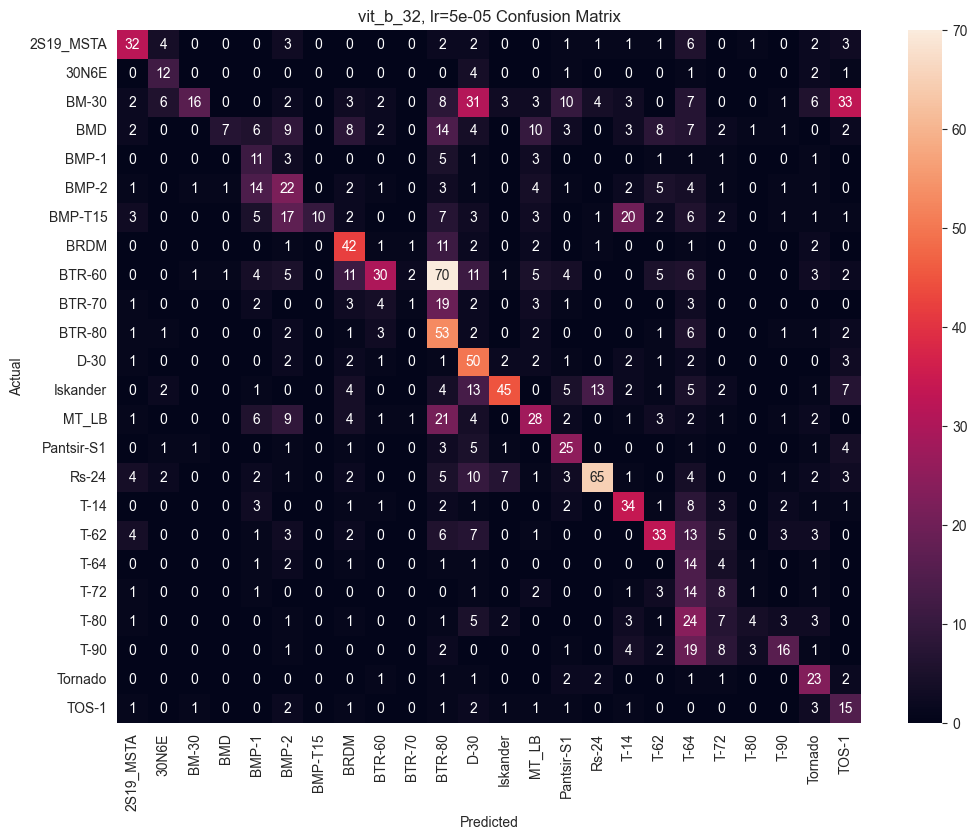

vit_b_32, lr=5e-05, 2S19_MSTA: Precision = 0.58
vit_b_32, lr=5e-05, 30N6E: Precision = 0.43
vit_b_32, lr=5e-05, BM-30: Precision = 0.80
vit_b_32, lr=5e-05, BMD: Precision = 0.78
vit_b_32, lr=5e-05, BMP-1: Precision = 0.19
vit_b_32, lr=5e-05, BMP-2: Precision = 0.26
vit_b_32, lr=5e-05, BMP-T15: Precision = 1.00
vit_b_32, lr=5e-05, BRDM: Precision = 0.46
vit_b_32, lr=5e-05, BTR-60: Precision = 0.64
vit_b_32, lr=5e-05, BTR-70: Precision = 0.20
vit_b_32, lr=5e-05, BTR-80: Precision = 0.22
vit_b_32, lr=5e-05, D-30: Precision = 0.31
vit_b_32, lr=5e-05, Iskander: Precision = 0.73
vit_b_32, lr=5e-05, MT_LB: Precision = 0.40
vit_b_32, lr=5e-05, Pantsir-S1: Precision = 0.40
vit_b_32, lr=5e-05, Rs-24: Precision = 0.75
vit_b_32, lr=5e-05, T-14: Precision = 0.44
vit_b_32, lr=5e-05, T-62: Precision = 0.49
vit_b_32, lr=5e-05, T-64: Precision = 0.09
vit_b_32, lr=5e-05, T-72: Precision = 0.18
vit_b_32, lr=5e-05, T-80: Precision = 0.36
vit_b_32, lr=5e-05, T-90: Precision = 0.52
vit_b_32, lr=5e-05, Torna

<Figure size 640x480 with 0 Axes>

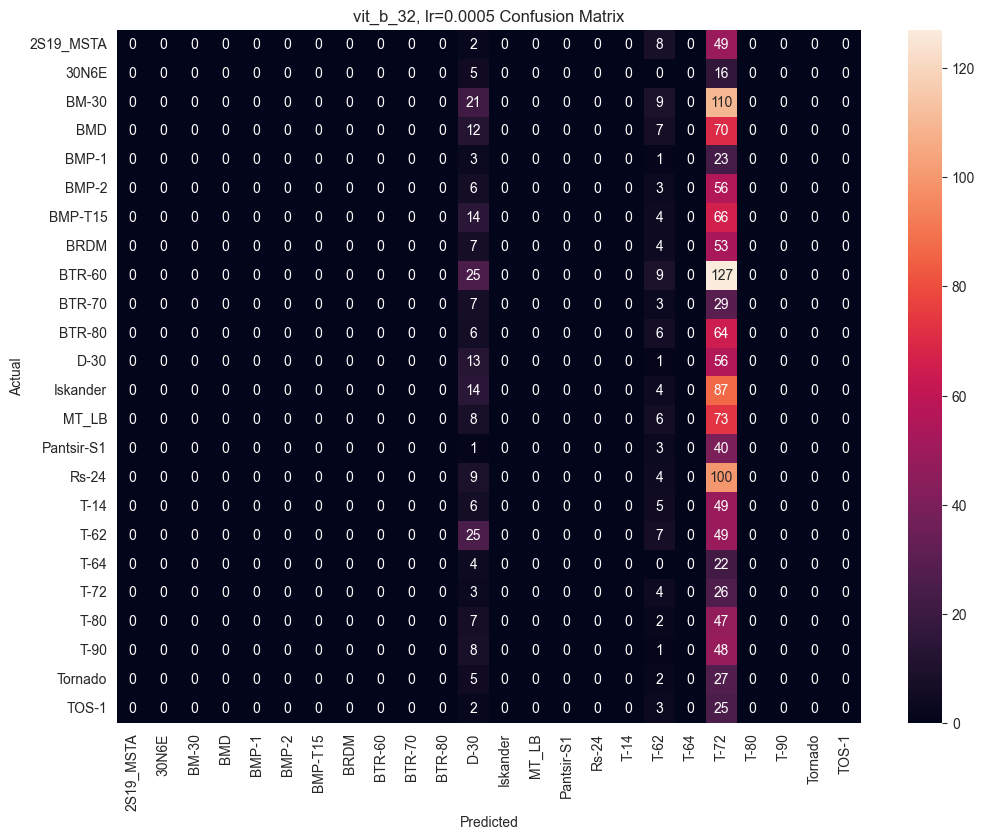

vit_b_32, lr=0.0005, 2S19_MSTA: Precision = 0.00
vit_b_32, lr=0.0005, 30N6E: Precision = 0.00
vit_b_32, lr=0.0005, BM-30: Precision = 0.00
vit_b_32, lr=0.0005, BMD: Precision = 0.00
vit_b_32, lr=0.0005, BMP-1: Precision = 0.00
vit_b_32, lr=0.0005, BMP-2: Precision = 0.00
vit_b_32, lr=0.0005, BMP-T15: Precision = 0.00
vit_b_32, lr=0.0005, BRDM: Precision = 0.00
vit_b_32, lr=0.0005, BTR-60: Precision = 0.00
vit_b_32, lr=0.0005, BTR-70: Precision = 0.00
vit_b_32, lr=0.0005, BTR-80: Precision = 0.00
vit_b_32, lr=0.0005, D-30: Precision = 0.06
vit_b_32, lr=0.0005, Iskander: Precision = 0.00
vit_b_32, lr=0.0005, MT_LB: Precision = 0.00
vit_b_32, lr=0.0005, Pantsir-S1: Precision = 0.00
vit_b_32, lr=0.0005, Rs-24: Precision = 0.00
vit_b_32, lr=0.0005, T-14: Precision = 0.00
vit_b_32, lr=0.0005, T-62: Precision = 0.07
vit_b_32, lr=0.0005, T-64: Precision = 0.00
vit_b_32, lr=0.0005, T-72: Precision = 0.02
vit_b_32, lr=0.0005, T-80: Precision = 0.00
vit_b_32, lr=0.0005, T-90: Precision = 0.00
vit

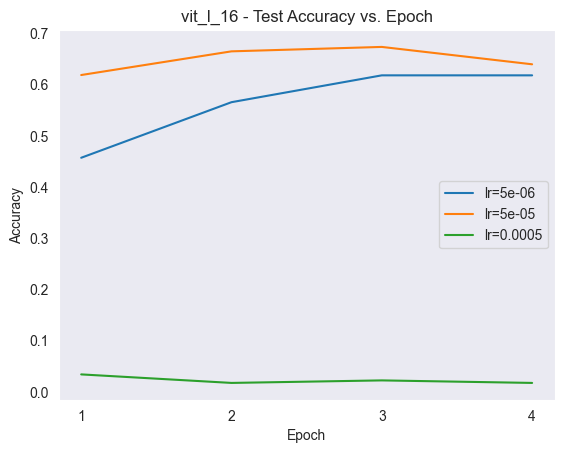

<Figure size 640x480 with 0 Axes>

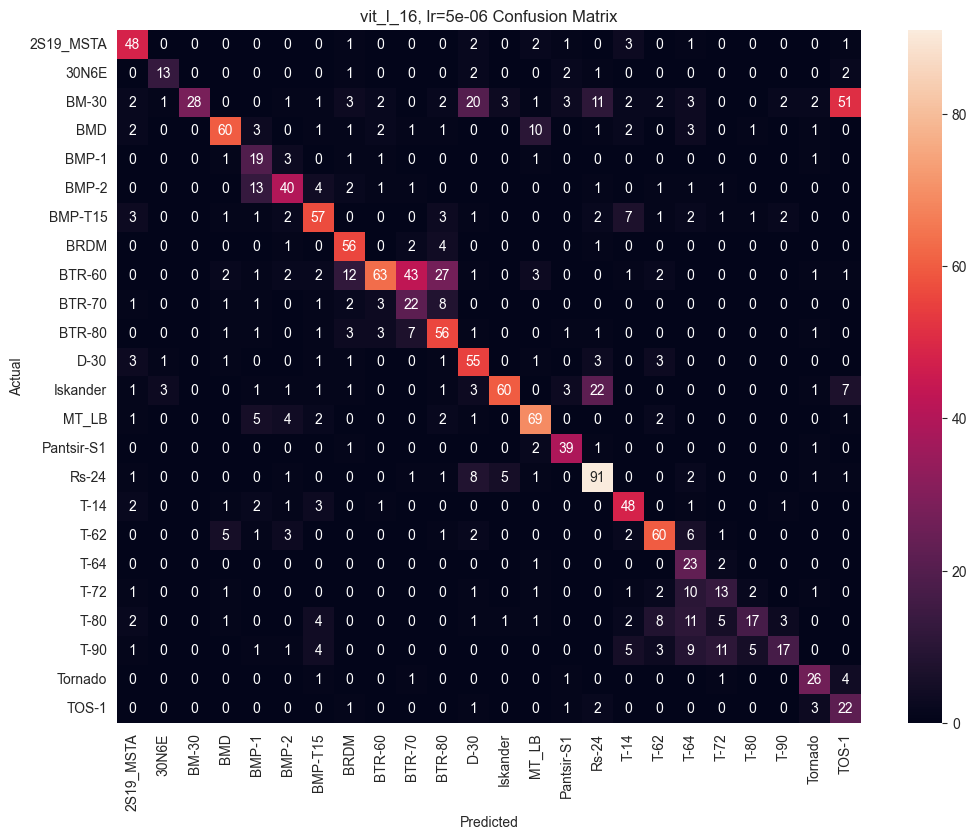

vit_l_16, lr=5e-06, 2S19_MSTA: Precision = 0.71
vit_l_16, lr=5e-06, 30N6E: Precision = 0.72
vit_l_16, lr=5e-06, BM-30: Precision = 1.00
vit_l_16, lr=5e-06, BMD: Precision = 0.80
vit_l_16, lr=5e-06, BMP-1: Precision = 0.39
vit_l_16, lr=5e-06, BMP-2: Precision = 0.67
vit_l_16, lr=5e-06, BMP-T15: Precision = 0.69
vit_l_16, lr=5e-06, BRDM: Precision = 0.65
vit_l_16, lr=5e-06, BTR-60: Precision = 0.83
vit_l_16, lr=5e-06, BTR-70: Precision = 0.28
vit_l_16, lr=5e-06, BTR-80: Precision = 0.52
vit_l_16, lr=5e-06, D-30: Precision = 0.56
vit_l_16, lr=5e-06, Iskander: Precision = 0.87
vit_l_16, lr=5e-06, MT_LB: Precision = 0.74
vit_l_16, lr=5e-06, Pantsir-S1: Precision = 0.76
vit_l_16, lr=5e-06, Rs-24: Precision = 0.66
vit_l_16, lr=5e-06, T-14: Precision = 0.66
vit_l_16, lr=5e-06, T-62: Precision = 0.71
vit_l_16, lr=5e-06, T-64: Precision = 0.32
vit_l_16, lr=5e-06, T-72: Precision = 0.37
vit_l_16, lr=5e-06, T-80: Precision = 0.65
vit_l_16, lr=5e-06, T-90: Precision = 0.68
vit_l_16, lr=5e-06, Torna

<Figure size 640x480 with 0 Axes>

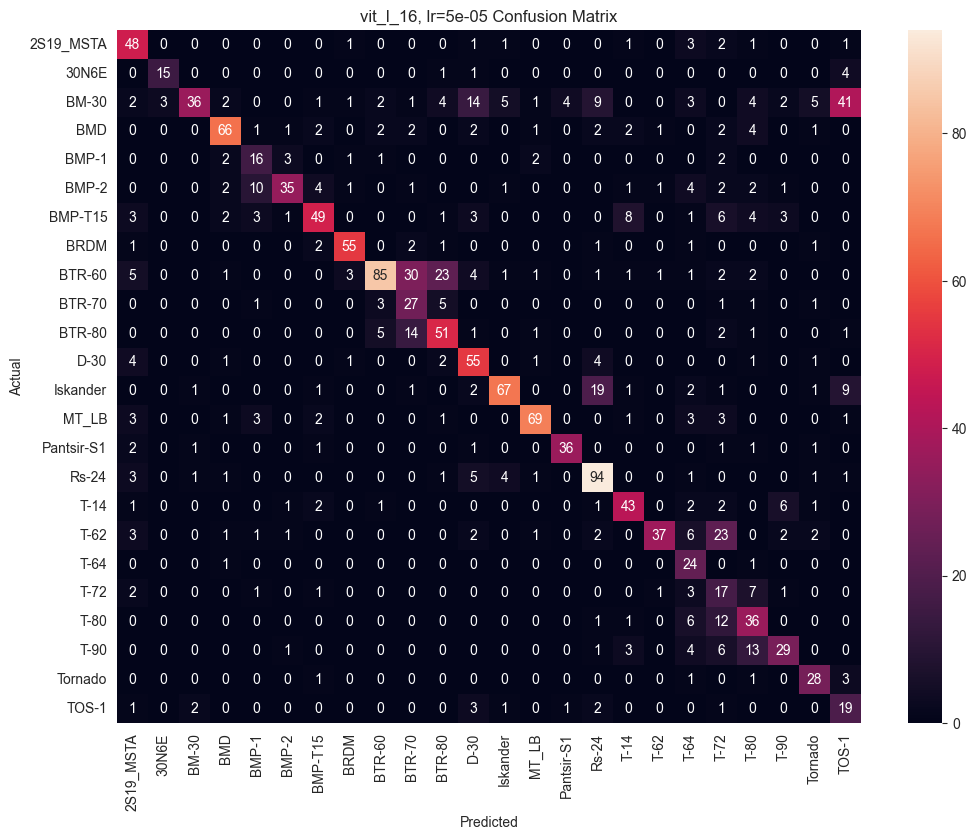

vit_l_16, lr=5e-05, 2S19_MSTA: Precision = 0.62
vit_l_16, lr=5e-05, 30N6E: Precision = 0.83
vit_l_16, lr=5e-05, BM-30: Precision = 0.88
vit_l_16, lr=5e-05, BMD: Precision = 0.82
vit_l_16, lr=5e-05, BMP-1: Precision = 0.44
vit_l_16, lr=5e-05, BMP-2: Precision = 0.81
vit_l_16, lr=5e-05, BMP-T15: Precision = 0.74
vit_l_16, lr=5e-05, BRDM: Precision = 0.87
vit_l_16, lr=5e-05, BTR-60: Precision = 0.86
vit_l_16, lr=5e-05, BTR-70: Precision = 0.35
vit_l_16, lr=5e-05, BTR-80: Precision = 0.57
vit_l_16, lr=5e-05, D-30: Precision = 0.59
vit_l_16, lr=5e-05, Iskander: Precision = 0.84
vit_l_16, lr=5e-05, MT_LB: Precision = 0.88
vit_l_16, lr=5e-05, Pantsir-S1: Precision = 0.88
vit_l_16, lr=5e-05, Rs-24: Precision = 0.69
vit_l_16, lr=5e-05, T-14: Precision = 0.69
vit_l_16, lr=5e-05, T-62: Precision = 0.90
vit_l_16, lr=5e-05, T-64: Precision = 0.37
vit_l_16, lr=5e-05, T-72: Precision = 0.20
vit_l_16, lr=5e-05, T-80: Precision = 0.46
vit_l_16, lr=5e-05, T-90: Precision = 0.66
vit_l_16, lr=5e-05, Torna

<Figure size 640x480 with 0 Axes>

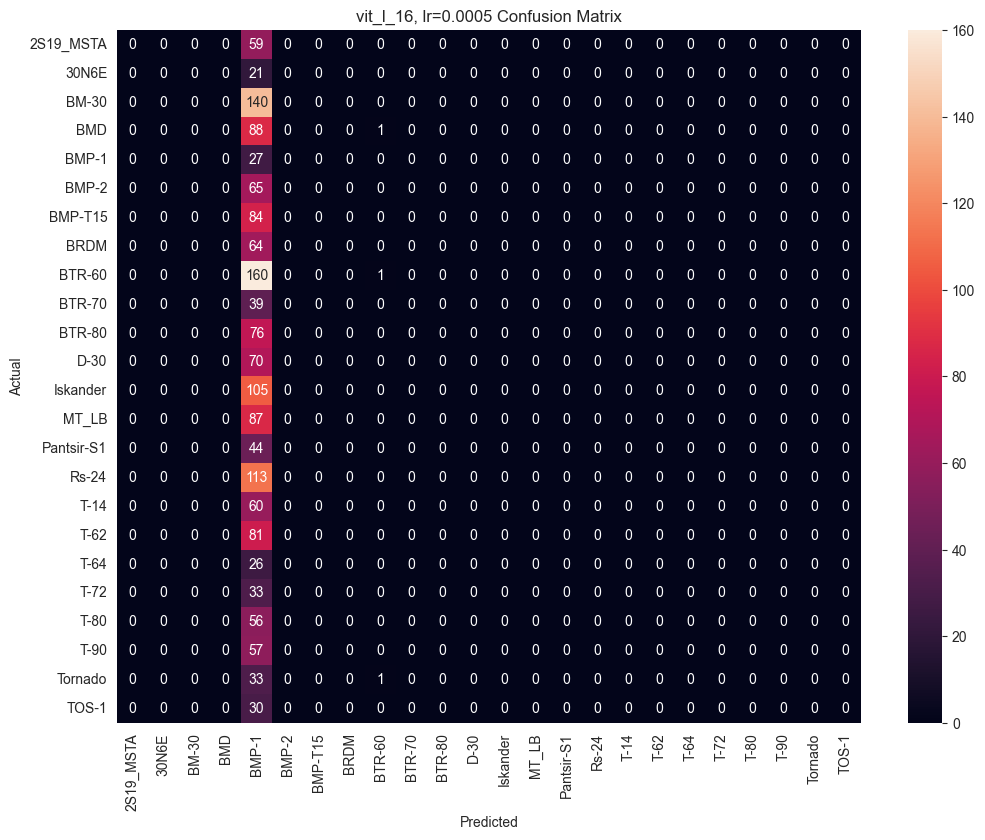

vit_l_16, lr=0.0005, 2S19_MSTA: Precision = 0.00
vit_l_16, lr=0.0005, 30N6E: Precision = 0.00
vit_l_16, lr=0.0005, BM-30: Precision = 0.00
vit_l_16, lr=0.0005, BMD: Precision = 0.00
vit_l_16, lr=0.0005, BMP-1: Precision = 0.02
vit_l_16, lr=0.0005, BMP-2: Precision = 0.00
vit_l_16, lr=0.0005, BMP-T15: Precision = 0.00
vit_l_16, lr=0.0005, BRDM: Precision = 0.00
vit_l_16, lr=0.0005, BTR-60: Precision = 0.33
vit_l_16, lr=0.0005, BTR-70: Precision = 0.00
vit_l_16, lr=0.0005, BTR-80: Precision = 0.00
vit_l_16, lr=0.0005, D-30: Precision = 0.00
vit_l_16, lr=0.0005, Iskander: Precision = 0.00
vit_l_16, lr=0.0005, MT_LB: Precision = 0.00
vit_l_16, lr=0.0005, Pantsir-S1: Precision = 0.00
vit_l_16, lr=0.0005, Rs-24: Precision = 0.00
vit_l_16, lr=0.0005, T-14: Precision = 0.00
vit_l_16, lr=0.0005, T-62: Precision = 0.00
vit_l_16, lr=0.0005, T-64: Precision = 0.00
vit_l_16, lr=0.0005, T-72: Precision = 0.00
vit_l_16, lr=0.0005, T-80: Precision = 0.00
vit_l_16, lr=0.0005, T-90: Precision = 0.00
vit

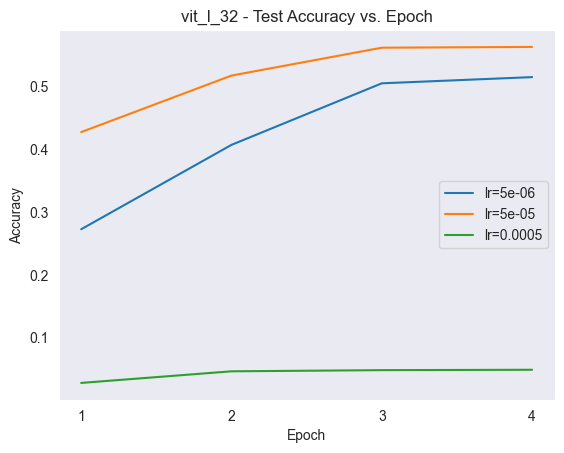

<Figure size 640x480 with 0 Axes>

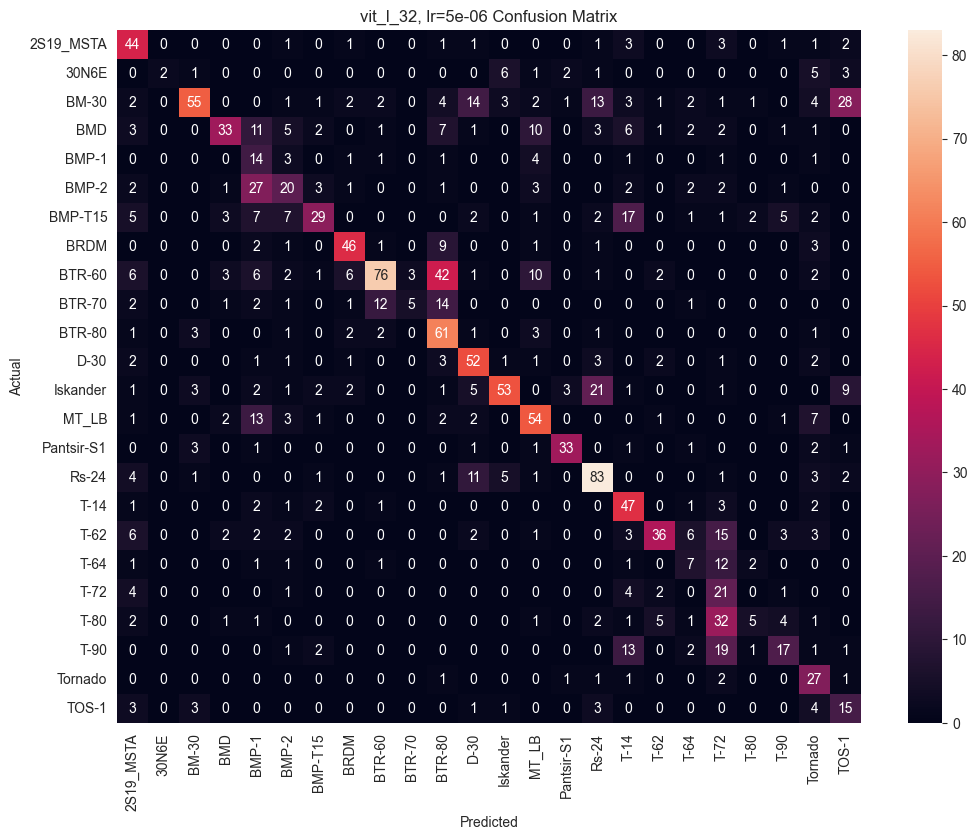

vit_l_32, lr=5e-06, 2S19_MSTA: Precision = 0.49
vit_l_32, lr=5e-06, 30N6E: Precision = 1.00
vit_l_32, lr=5e-06, BM-30: Precision = 0.80
vit_l_32, lr=5e-06, BMD: Precision = 0.72
vit_l_32, lr=5e-06, BMP-1: Precision = 0.15
vit_l_32, lr=5e-06, BMP-2: Precision = 0.38
vit_l_32, lr=5e-06, BMP-T15: Precision = 0.66
vit_l_32, lr=5e-06, BRDM: Precision = 0.73
vit_l_32, lr=5e-06, BTR-60: Precision = 0.78
vit_l_32, lr=5e-06, BTR-70: Precision = 0.62
vit_l_32, lr=5e-06, BTR-80: Precision = 0.41
vit_l_32, lr=5e-06, D-30: Precision = 0.55
vit_l_32, lr=5e-06, Iskander: Precision = 0.77
vit_l_32, lr=5e-06, MT_LB: Precision = 0.57
vit_l_32, lr=5e-06, Pantsir-S1: Precision = 0.82
vit_l_32, lr=5e-06, Rs-24: Precision = 0.61
vit_l_32, lr=5e-06, T-14: Precision = 0.45
vit_l_32, lr=5e-06, T-62: Precision = 0.72
vit_l_32, lr=5e-06, T-64: Precision = 0.27
vit_l_32, lr=5e-06, T-72: Precision = 0.18
vit_l_32, lr=5e-06, T-80: Precision = 0.45
vit_l_32, lr=5e-06, T-90: Precision = 0.50
vit_l_32, lr=5e-06, Torna

<Figure size 640x480 with 0 Axes>

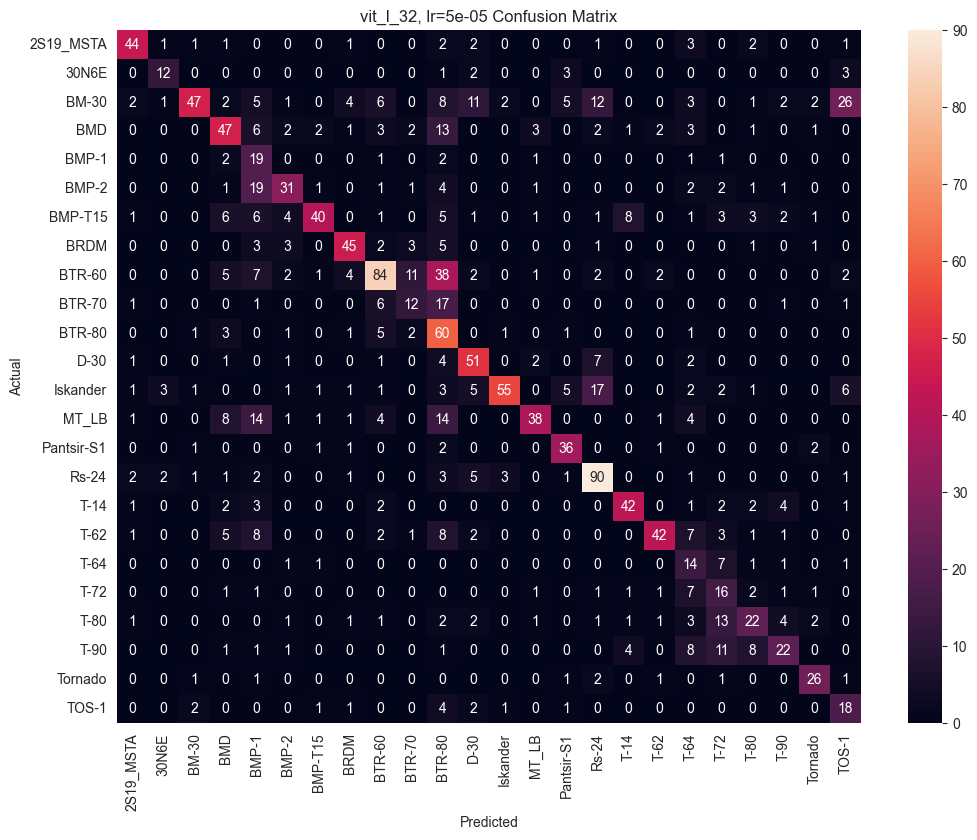

vit_l_32, lr=5e-05, 2S19_MSTA: Precision = 0.79
vit_l_32, lr=5e-05, 30N6E: Precision = 0.63
vit_l_32, lr=5e-05, BM-30: Precision = 0.85
vit_l_32, lr=5e-05, BMD: Precision = 0.55
vit_l_32, lr=5e-05, BMP-1: Precision = 0.20
vit_l_32, lr=5e-05, BMP-2: Precision = 0.62
vit_l_32, lr=5e-05, BMP-T15: Precision = 0.82
vit_l_32, lr=5e-05, BRDM: Precision = 0.73
vit_l_32, lr=5e-05, BTR-60: Precision = 0.70
vit_l_32, lr=5e-05, BTR-70: Precision = 0.38
vit_l_32, lr=5e-05, BTR-80: Precision = 0.31
vit_l_32, lr=5e-05, D-30: Precision = 0.60
vit_l_32, lr=5e-05, Iskander: Precision = 0.89
vit_l_32, lr=5e-05, MT_LB: Precision = 0.78
vit_l_32, lr=5e-05, Pantsir-S1: Precision = 0.68
vit_l_32, lr=5e-05, Rs-24: Precision = 0.66
vit_l_32, lr=5e-05, T-14: Precision = 0.74
vit_l_32, lr=5e-05, T-62: Precision = 0.82
vit_l_32, lr=5e-05, T-64: Precision = 0.22
vit_l_32, lr=5e-05, T-72: Precision = 0.26
vit_l_32, lr=5e-05, T-80: Precision = 0.48
vit_l_32, lr=5e-05, T-90: Precision = 0.56
vit_l_32, lr=5e-05, Torna

<Figure size 640x480 with 0 Axes>

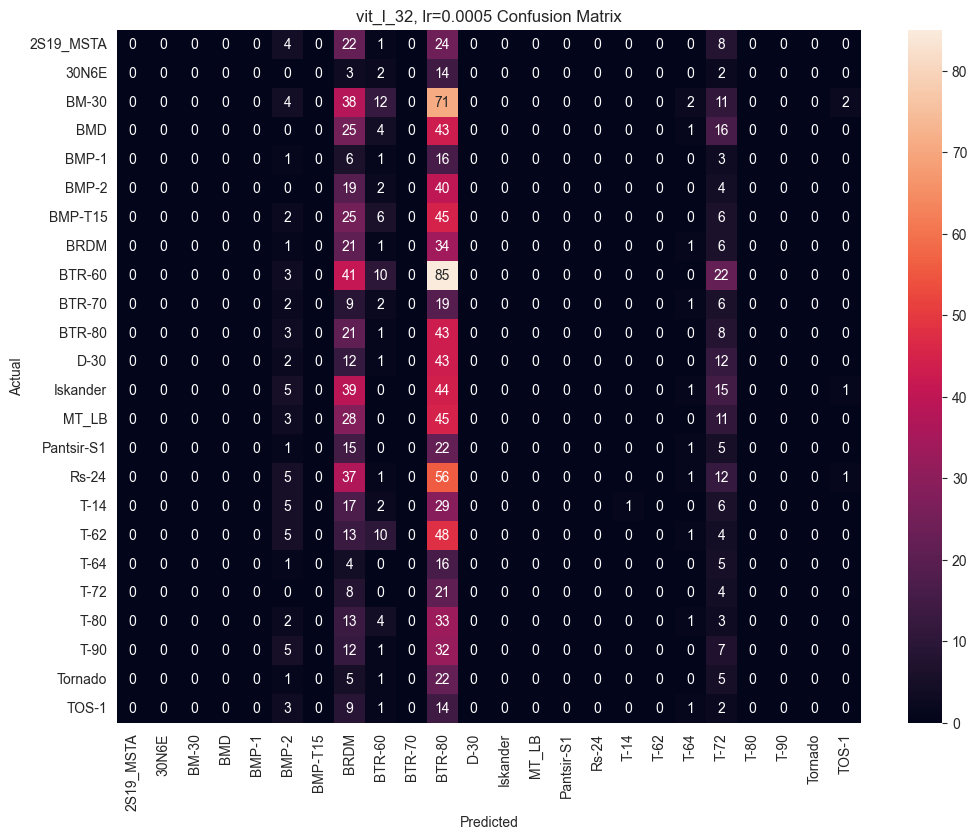

vit_l_32, lr=0.0005, 2S19_MSTA: Precision = 0.00
vit_l_32, lr=0.0005, 30N6E: Precision = 0.00
vit_l_32, lr=0.0005, BM-30: Precision = 0.00
vit_l_32, lr=0.0005, BMD: Precision = 0.00
vit_l_32, lr=0.0005, BMP-1: Precision = 0.00
vit_l_32, lr=0.0005, BMP-2: Precision = 0.00
vit_l_32, lr=0.0005, BMP-T15: Precision = 0.00
vit_l_32, lr=0.0005, BRDM: Precision = 0.05
vit_l_32, lr=0.0005, BTR-60: Precision = 0.16
vit_l_32, lr=0.0005, BTR-70: Precision = 0.00
vit_l_32, lr=0.0005, BTR-80: Precision = 0.05
vit_l_32, lr=0.0005, D-30: Precision = 0.00
vit_l_32, lr=0.0005, Iskander: Precision = 0.00
vit_l_32, lr=0.0005, MT_LB: Precision = 0.00
vit_l_32, lr=0.0005, Pantsir-S1: Precision = 0.00
vit_l_32, lr=0.0005, Rs-24: Precision = 0.00
vit_l_32, lr=0.0005, T-14: Precision = 1.00
vit_l_32, lr=0.0005, T-62: Precision = 0.00
vit_l_32, lr=0.0005, T-64: Precision = 0.00
vit_l_32, lr=0.0005, T-72: Precision = 0.02
vit_l_32, lr=0.0005, T-80: Precision = 0.00
vit_l_32, lr=0.0005, T-90: Precision = 0.00
vit

<Figure size 640x480 with 0 Axes>

In [5]:
def plot_test_metrics():
    # Now, create plots for test accuracy vs. epoch for each model
    for model_name, model_data in sorted(model_test_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        metric = 'Accuracy'
        
        with Plot():
            plt.title(f"{model_name} - Test {metric} vs. Epoch")
            plt.xlabel('Epoch')
            plt.ylabel(metric)
    
            for lr_value, lr_data in sorted(model_data.items()):
                # Sort the data based on the number of epochs
                epochs, epoch_data = zip(*sorted(lr_data.items()))
                plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'lr={lr_value}')
                plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
    
            plt.legend()
            plt.grid()
        
        for lr_value, lr_data in sorted(model_data.items()):
            epochs, epoch_data = zip(*sorted(lr_data.items()))
            
            with Plot():
                plt.figure(figsize=(12, 9))
                sns.heatmap(epoch_data[-1]['cm'], 
                            annot=True, 
                            fmt="d",  
                            xticklabels=fine_grain_classes, 
                            yticklabels=fine_grain_classes
                            )
                
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.title(f'{model_name}, lr={lr_value} Confusion Matrix')
            
            for class_label, class_name in enumerate(fine_grain_classes):
                precision = epoch_data[-1]['pre'][class_label]
                # recall = recall_per_class[class_label]
                print(f'{model_name}, lr={lr_value}, {class_name}: Precision = {precision:.2f}')

            
plot_test_metrics()

In [26]:

for filename in os.listdir(f'{data_dir}/figs'):
    match = re.match(pattern=rf'main_(.+?)_lr(.+?)_secondary_(.+?)_lr(.+)',
                     string=filename)
    if match:
        main_model_name, main_lr, secondary_model_name, secondary_lr = (match.group(i) for i in range(1,5))
        prior_predictions = np.load(os.path.join(data_dir, 
                                                 rf'{main_model_name}_test_pred_lr{main_lr}_e3.npy'))
        prior_acc = accuracy_score(test_true, prior_predictions)
        
        post_predictions = np.load(f'{data_dir}/figs/{match.group(0)}/results.npy')
        posterior_acc = accuracy_score(test_true, post_predictions)
        print('#' * 100 + f'Main: {main_model_name} with lr {main_lr}, '
                          f'secondary: {secondary_model_name} with lr {secondary_lr}\n'
              f'Prior acc:{prior_acc}, post acc: {posterior_acc}\n')
        print(termcolor.colored(f"Total acc change {'+' if posterior_acc > prior_acc else ''}"
                                f"{round((posterior_acc - prior_acc)*100, 3)}%", 
                                'green' if posterior_acc > prior_acc else 'red'))

####################################################################################################Main: vit_l_32 with lr 5e-06, secondary: b_32 with lr 5e-05
Prior acc:0.5151141270820481, post acc: 0.5089450956199877

Total acc change -0.617%
####################################################################################################Main: vit_b_16 with lr 0.0005, secondary: b_32 with lr 5e-05
Prior acc:0.07896360271437385, post acc: 0.01850709438618137

Total acc change -6.046%
####################################################################################################Main: vit_b_32 with lr 5e-06, secondary: b_16 with lr 5e-05
Prior acc:0.5342381246144355, post acc: 0.6255397902529303

Total acc change +9.13%
####################################################################################################Main: vit_b_32 with lr 5e-05, secondary: b_16 with lr 5e-05
Prior acc:0.3676742751388032, post acc: 0.582356570018507

Total acc change +21.468%
##################

In [31]:
# Now, create a table of test accuracies per model and per learning rate
table_data = []

for model_name, lr_data in model_test_data.items():
    for lr_value, accuracy in lr_data.items():
        table_data.append([model_name, lr_value, accuracy])

# Create the table using tabulate
table_headers = ["Model", "Learning Rate", "Test Accuracy"]
table = tabulate(table_data, headers=table_headers, floatfmt=(".2f", ".5f"))

print(table)

Model       Learning Rate  Test Accuracy
--------  ---------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vit_b_16          0.00005  {2: {'acc': 0.581122763726095, 'cm': array([[49,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,
                                    0,  1,  0,  0,  3,  0,  1,  0],
                                  [ 0, 10,  4,  0,  1,  0,  0,  0,  0,  0,  0,  2,  0,  0,  1,  0,
                                    0,  0,  0,  0,  0,  0,  1,  2],
                                  [ 0,  0, 89,  2,  1,  0,  0,  2,  2,  1,  1, 22,  1,  1,  0,  4,
                                    0,  0,  0,  0,  2,  2,  1,  9],
                                  [ 0,  0,  1, 64,  6,  0,  1,  0,  3,  0,  1,  3,  0,  2,  0,  1,
                                    2,  1,  0,  0,  2,  1,  0,  1],
                                  [ 0,  0,  0,  3, 21,  0